In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.auto import tqdm
import torch
from torch import nn
import gin
import ray
import pickle
import io
gin.enter_interactive_mode()
from causal_util import load_env
from causal_util.helpers import lstdct2dctlst
from sparse_causal_model_learner_rl.loss.losses import fit_loss
from sparse_causal_model_learner_rl.loss.causal_discriminator import siamese_feature_discriminator_l2

from sparse_causal_model_learner_rl.metrics.context_rewrite import context_rewriter
from sparse_causal_model_learner_rl.visual.learner_visual import graph_for_matrices
from sparse_causal_model_learner_rl.config import Config
from sparse_causal_model_learner_rl.sacred_gin_tune.sacred_wrapper import load_config_files
from sparse_causal_model_learner_rl.learners.rl_learner import CausalModelLearnerRL

In [2]:
load_config_files(['../sparse_causal_model_learner_rl/configs/kc_rec_nonlin_gnn_gumbel_siamese_l2-Copy1.gin',
                   '../sparse_causal_model_learner_rl/configs/kc_dec.gin',
                   '../keychest/config/5x5_1f1c1k_obs.gin',
                   '../sparse_causal_model_learner_rl/configs/server_collect.gin'])

['kc_rec_nonlin_gnn_gumbel_siamese_l2-Copy1',
 'kc_dec',
 '5x5_1f1c1k_obs',
 'server_collect']

In [3]:
gin.bind_parameter('Config.env_steps', 5000)
gin.bind_parameter('Config.rl_multistep', [3])
gin.bind_parameter('Config.env_steps', 5000)
gin.bind_parameter('Config.minibatch_size', 5000)
gin.bind_parameter('Normalizer.type_', 'meanstd')
gin.bind_parameter('ManyNetworkCombinedModel.input_batchnorm', True)

In [4]:
ray.init(ignore_reinit_error=True)

2021-02-09 05:53:03,745	INFO services.py:1092 -- View the Ray dashboard at http://127.0.0.1:8266


{'node_ip_address': '10.90.38.7',
 'raylet_ip_address': '10.90.38.7',
 'redis_address': '10.90.38.7:24179',
 'object_store_address': '/tmp/ray/session_2021-02-09_05-53-03_074694_28402/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-02-09_05-53-03_074694_28402/sockets/raylet',
 'webui_url': '127.0.0.1:8266',
 'session_dir': '/tmp/ray/session_2021-02-09_05-53-03_074694_28402',
 'metrics_export_port': 35145,
 'node_id': '3991054fe316f53d50c19dff3cdc3bf903c0d719'}

In [5]:
# gin.bind_parameter('decoder/FCNet.hidden_sizes', [512, 256])
# gin.bind_parameter('decoder/FCNet.activation_cls', torch.nn.LeakyReLU)

In [6]:
gin.bind_parameter('decoder/FCNet.hidden_sizes', [512])
gin.bind_parameter('decoder/FCNet.activation_cls', torch.nn.LeakyReLU)

In [7]:
learner = CausalModelLearnerRL(Config(ray_kwargs={'address': '127.0.0.1:6379'}))

2021-02-09 05:53:05,851	WARNING session.py:20 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Selecting name b294b0dc-6a92-11eb-8ff1-90e2baa1a248
Make environment KeyChest-v0 None {}


(pid=28790) Make environment KeyChest-v0 None {}
(pid=28803) Make environment KeyChest-v0 None {}
(pid=28814) Make environment KeyChest-v0 None {}
(pid=28714) Make environment KeyChest-v0 None {}
(pid=28719) Make environment KeyChest-v0 None {}
(pid=28715) Make environment KeyChest-v0 None {}
(pid=28716) Make environment KeyChest-v0 None {}



In [8]:
learner.create_trainables()

In [9]:
learner.decoder

ModelDecoder(
  (model): FCNet(
    (fc01): Linear(in_features=847, out_features=512, bias=True)
    (fc02): Linear(in_features=512, out_features=30, bias=True)
  )
)

In [10]:
env = learner.env

In [11]:
learner.decoder.__init__(observation_shape=learner.observation_shape,
                         feature_shape=learner.feature_shape)
learner.decoder = learner.decoder.cuda()

In [12]:
losses = []
dclose = []
dfar = []

In [13]:
opt = torch.optim.Adam(lr=1e-3, params=learner.decoder.parameters(),
                      betas=(0.5, 0.9))

In [14]:
ctx = learner.collect_and_get_context()

In [43]:
ctx['additional_feature_keys']

['rew_y', 'done_y']

In [96]:
for i in tqdm(range(1000)):
    if i % 1 == 0:
        ctx = learner.collect_and_get_context()
    
    opt.zero_grad()
    l_obj = siamese_feature_discriminator_l2(**ctx)
    loss = l_obj['loss']
    loss.backward()
    opt.step()
    losses.append(loss.item())
    dclose.append(l_obj['metrics']['distance_close'])
    dfar.append(l_obj['metrics']['distance_far'])

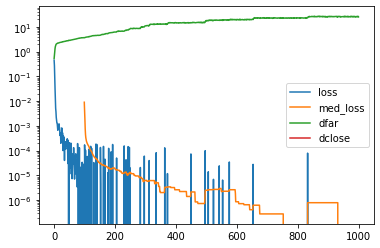

In [108]:
plt.plot(losses, label='loss')
plt.plot(pd.Series(losses).rolling(100).mean(), label='med_loss')
plt.plot(dfar, label='dfar')
plt.plot(dclose, label='dclose')
plt.yscale('log')
plt.legend()

In [98]:
np.mean(losses[-50:]), np.median(losses[-50:])

(0.0, 0.0)

In [99]:
ctx = learner.collect_and_get_context()

In [100]:
features = learner.decoder(ctx['obs'])

In [54]:
f = features.detach().cpu().numpy()

NameError: name 'features' is not defined

In [55]:
f.shape

NameError: name 'f' is not defined

In [56]:
plt.figure(figsize=(20, 25))
for i_f in range(f.shape[1]):
    plt.subplot(10, 3, i_f + 1)
    plt.hist(f[:, i_f])

NameError: name 'f' is not defined

<Figure size 1440x1800 with 0 Axes>

In [57]:
pd.DataFrame(f).std()

NameError: name 'f' is not defined

In [58]:
sns.heatmap(pd.DataFrame(f).corr())

NameError: name 'f' is not defined

In [59]:
env.engine.return_rgb = False

In [83]:
gin.bind_parameter('model_gnn/FCCombinedModel.activation_cls', torch.nn.Tanh)
gin.bind_parameter('model_gnn/FCCombinedModel.hidden_sizes', [100, 100, 100])
gin.bind_parameter('ManyNetworkCombinedModel.input_batchnorm', False)

In [84]:
learner.non_sparse_model.__init__(feature_shape=learner.feature_shape,
                                  action_shape=learner.action_shape,
                                  additional_feature_shape=learner.additional_feature_shape)
learner.non_sparse_model = learner.non_sparse_model.cuda()

In [85]:
learner.non_sparse_model.model.model.activation

[Tanh(), Tanh(), Tanh(), None]

In [86]:
learner.non_sparse_model

ManyNetworkCombinedModel(
  (model): WithInputSwitch(
    (switch): LearnableSwitchSimple()
    (model): FCCombinedModel(
      (fc01): CombinedLinearLayer()
      (fc02): CombinedLinearLayer()
      (fc03): CombinedLinearLayer()
      (fc04): CombinedLinearLayer()
    )
  )
)

In [87]:
learner.non_sparse_model.model.enable_switch

False

In [88]:
mins = None
maxes = None

In [89]:
def normalize(t, mins, maxes):
    return 2 * ((t - mins) / (1e-3 + maxes - mins) - 0.5)

In [90]:
class AdhocWorldModel(nn.Module):
    def __init__(self):
        super(AdhocWorldModel, self).__init__()
        dim = 60
        self.bn = torch.nn.BatchNorm1d(num_features=34)
        self.fc1 = nn.Linear(in_features=34, out_features=dim)
        self.fc2 = nn.Linear(in_features=dim, out_features=dim)
        self.fc3 = nn.Linear(in_features=dim, out_features=dim)
        self.fc4 = nn.Linear(in_features=dim, out_features=32)
        self.activation = nn.Tanh()
        
    def forward(self, f_t, a_t, all):
        x = torch.cat([f_t, a_t], dim=1)
        
        x = self.bn(x)
        
        x = self.fc1(x)
        x = self.activation(x)
        
        x = self.fc2(x)
        x = self.activation(x)
        
        x = self.fc3(x)
        x = self.activation(x)
        
        x = self.fc4(x)
        return x

In [91]:
losses = []
metrics = []
losses_emb = []
losses_fit = []
ratios = []
ctx_set = False

In [92]:
use_model = learner.non_sparse_model
#use_model = AdhocWorldModel().cuda()

In [93]:
gin.bind_parameter('decoder/FCNet.hidden_sizes', [512, 256])
gin.bind_parameter('decoder/FCNet.activation_cls', torch.nn.LeakyReLU)

In [94]:
learner.decoder.__init__(observation_shape=learner.observation_shape,
                         feature_shape=learner.feature_shape)
learner.decoder = learner.decoder.cuda()

In [95]:
def delta_multistep(model, decoder, steps, additional_feature_keys, **ctx):
    """Return multi-step prediction error with additional features."""
    obs_first = ctx[f'multistep_{steps}_obs_1']
    obs_last = ctx[f'multistep_{steps}_obs_{steps}']
    acts = [ctx[f'multistep_{steps}_act_{s}'] for s in range(1, steps)]
    
    add_features_noy = [x[:-2] for x in additional_feature_keys]
    additional_feature_keys_multistep = [f'multistep_{steps}_{n}_{steps-1}' for n in add_features_noy]
    
    f_t = decoder(obs_first)
    n_features = f_t.shape[1]

    for a_t in acts:
        f_t = model(f_t=f_t[:, :n_features], a_t=a_t, all=True)

    f_last_1 = decoder(obs_last)
    f_last = torch.cat([f_last_1] + [ctx[k] for k in additional_feature_keys_multistep], dim=1)
    delta = f_last - f_t
    return delta

In [96]:
def fit_loss(obs_x, obs_y, action_x, decoder, model, additional_feature_keys,
             model_forward_kwargs=None,
             fill_switch_grad=False,
             opt_label=None,
             divide_by_std=False,
             std_eps=0.05,
             **kwargs):
    """Ensure that the model fits the features data."""

    if model_forward_kwargs is None:
        model_forward_kwargs = {}
    
    f_t1 = decoder(obs_y)#.detach()
        
    have_additional = False
    if additional_feature_keys:
        have_additional = True
        add_features_y = torch.cat([kwargs[k] for k in additional_feature_keys], dim=1)
        
        # WARNING: zeroing output features
#         f_t1 = torch.zeros_like(f_t1)
        f_t1 = torch.cat([f_t1, add_features_y], dim=1)
        
    # detaching second part like in q-learning makes the loss jitter

    f_t1_pred = model(decoder(obs_x), action_x, all=have_additional, **model_forward_kwargs)

    loss = (f_t1_pred - f_t1).pow(2)
    loss = loss.sum(1).mean()

    metrics = {'mean_feature': f_t1.mean(0).detach().cpu().numpy(),
               'std_feature': f_t1.std(0).detach().cpu().numpy(),
               'min_feature': f_t1.min().item(),
               'max_feature': f_t1.max().item(),
               #'std_feature_avg': f_t1_std.detach().cpu().numpy() if f_t1_std is not None else 0.0,
               #'inv_std_feature_avg': 1/f_t1_std.detach().cpu().numpy() if f_t1_std is not None else 0.0
              }
    
    delta_3step = delta_multistep(model=model, decoder=decoder, steps=3, additional_feature_keys=additional_feature_keys,
                                  **kwargs)
    loss_3step = delta_3step.pow(2).sum(1).mean()

    metrics['loss_1step'] = loss.item()
    metrics['loss_3step'] = loss_3step.item()

    loss += loss_3step
    
    return {'loss': loss,
            'metrics': metrics}

In [97]:
opt_m = torch.optim.Adam(lr=1e-3, params=list(use_model.parameters()),# + list(learner.decoder.parameters()),
                      #amsgrad=True,
                       betas=(0.5, 0.8)
                      )
opt_d = torch.optim.Adam(lr=1e-3, params=list(learner.decoder.parameters()),
                      #amsgrad=True,
                       betas=(0.5, 0.8)
                      )
opt_md = torch.optim.Adam(lr=1e-3, params=list(learner.decoder.parameters())+list(use_model.parameters()),
                      #amsgrad=True,
                       betas=(0.5, 0.8)
                      )

In [98]:
[x.mean() for x in learner.decoder.state_dict().values()]

[tensor(-7.7709e-07, device='cuda:0'),
 tensor(-0.0012, device='cuda:0'),
 tensor(-8.1246e-05, device='cuda:0'),
 tensor(0.0012, device='cuda:0'),
 tensor(-0.0002, device='cuda:0'),
 tensor(0.0172, device='cuda:0')]

In [ ]:
epochs = 500000
with tqdm(total=epochs) as pbar:
    for i in range(epochs):
        if i % 1 == 0 or not ctx_set:
            ctx_set = True
            ctx = learner.collect_and_get_context()
            ratio = ctx.get('context_stats_collected_sampled_ratio', None)
            if ratio:
                ratios.append(ratio)
            elif ratios:
                ratios.append(ratios[-1])

    #         if mins is None or maxes is None:
    #             print("Computing minmax")
    #             f_all = learner.decoder(ctx['obs'])
    #             mins = f_all.min(dim=0, keepdim=True).values.detach()
    #             maxes = f_all.max(dim=0, keepdim=True).values.detach()

    #         f_t1 = learner.decoder(ctx['obs_y'])#.detach()
    #         f_t = learner.decoder(ctx['obs_x'])#.detach()

    # #         f_t1 = normalize(f_t1, mins, maxes)
    # #         f_t = normalize(f_t, mins, maxes)

    #         add_features_y = torch.cat([ctx[k] for k in ctx['additional_feature_keys']], dim=1)
    #         f_t1 = torch.cat([f_t1, add_features_y], dim=1)

    #     f_t1_pred = use_model(
    #         f_t,
    #         ctx['action_x'],
    #         all=True)

        ctx['non_sparse_model_add'] = use_model
    #     ctx['additional_feature_keys'] = []
        l_obj_fit = context_rewriter(function=fit_loss, rewrite={'model': 'non_sparse_model_add'},
                                     divide_by_std=False,
                                     **ctx)
        l_obj_emb = siamese_feature_discriminator_l2(**ctx)

        loss = l_obj_fit['loss'] + l_obj_emb['loss']


    #     loss = nn.MSELoss()(f_t1, f_t1_pred)


        stage = (i // 100) % 3
        if stage == 0:
            opt_m.zero_grad()
#             l_obj_fit['loss'].backward()
            loss.backward()
    #         loss.backward()
            opt_m.step()
        elif stage == 1:
            opt_d.zero_grad()
#             l_obj_emb = siamese_feature_discriminator_l2(**ctx)

#             l_obj_emb['loss'].backward()
            loss.backward()
            opt_d.step()
        elif stage == 2:
            opt_md.zero_grad()
            loss.backward()
            opt_md.step()
    
        losses.append(loss.item())
        losses_emb.append(l_obj_emb['loss'].item())
        losses_fit.append(l_obj_fit['loss'].item())
        m = {}
        m.update(l_obj_fit['metrics'])
        m.update(l_obj_emb['metrics'])
        metrics.append(m)
        pbar.update(1)
        pbar.set_postfix(loss_fit=losses_fit[-1], loss_emb=losses_emb[-1], stage=stage)

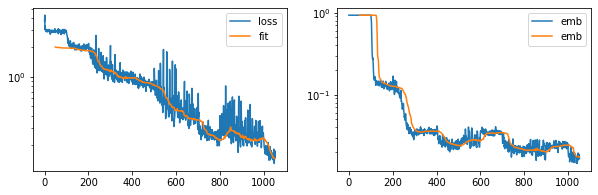

In [100]:
# multistep
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.plot(losses, label='loss')
plt.plot(pd.Series(losses_fit).rolling(50).median(), label='fit')
plt.legend()
plt.yscale('log')
plt.subplot(1, 2, 2)
plt.plot(losses_emb, label='emb')
plt.plot(pd.Series(losses_emb).rolling(50).median(), label='emb')

plt.legend()
#plt.plot(dplus, label='dplus')
plt.yscale('log')

In [ ]:
# 1 step
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.plot(losses, label='loss')
plt.plot(pd.Series(losses_fit).rolling(50).median(), label='fit')
plt.legend()
plt.yscale('log')
plt.subplot(1, 2, 2)
plt.plot(losses_emb, label='emb')
plt.plot(pd.Series(losses_emb).rolling(50).median(), label='emb')

plt.legend()
#plt.plot(dplus, label='dplus')
plt.yscale('log')

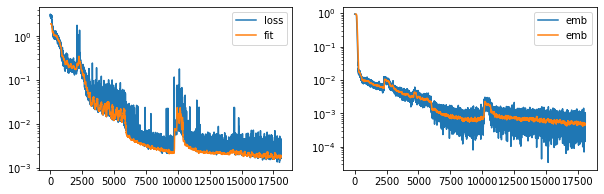

Text(0, 0.5, 'fit loss')

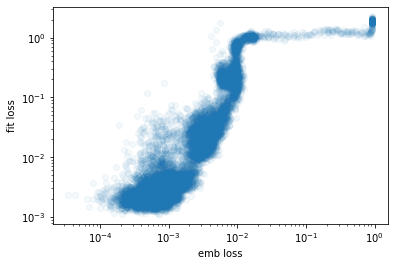

In [582]:
plt.scatter(losses_emb, losses_fit, alpha=0.05)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('emb loss')
plt.ylabel('fit loss')

In [605]:
%%javascript
var jq = document.createElement('script');
jq.src = "https://ajax.googleapis.com/ajax/libs/jquery/2.1.4/jquery.min.js";
document.getElementsByTagName('head')[0].appendChild(jq);

<IPython.core.display.Javascript object>

In [606]:
%load_ext jupyternotify
%autonotify -a 30

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


In [425]:
f_t1 = learner.decoder(ctx['obs_y'])#.detach()
f_t = learner.decoder(ctx['obs_x'])#.detach()

#         f_t1 = normalize(f_t1, mins, maxes)
#         f_t = normalize(f_t, mins, maxes)

add_features_y = torch.cat([ctx[k] for k in ctx['additional_feature_keys']], dim=1)
# f_t1 = torch.zeros_like(f_t1)
f_t1 = torch.cat([f_t1, add_features_y], dim=1)

f_t1_pred = use_model(
f_t,
ctx['action_x'],
all=True)


<AxesSubplot:>

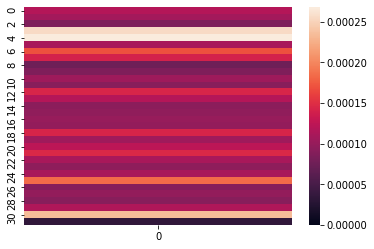

In [426]:
sns.heatmap((f_t1_pred - f_t1).pow(2).mean(0).cpu().detach().numpy().reshape(-1, 1), vmin=0)

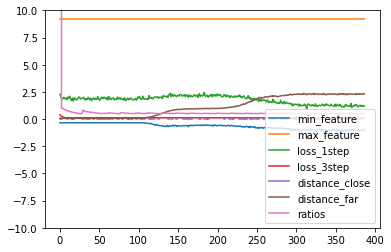

In [79]:
metrics_dct = lstdct2dctlst(metrics)
metrics_dct['ratios'] = ratios
for key, vals in metrics_dct.items():
    if len(np.array(vals).shape) > 1: continue
    plt.plot(vals, label=key)
plt.ylim((-10, 10))
plt.legend()
plt.show()

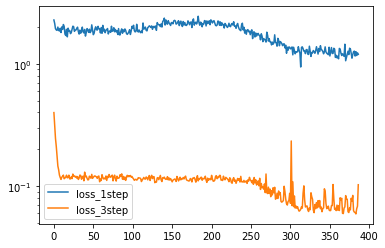

In [81]:
plt.yscale('log')
for key in ['loss_1step', 'loss_3step']:
    plt.plot(metrics_dct[key], label=key)
plt.legend()

In [428]:
metrics_dct.keys()

dict_keys(['mean_feature', 'std_feature', 'min_feature', 'max_feature', 'distance_close', 'distance_far', 'ratios'])

In [429]:
losses[-1]

0.0050888038240373135

In [430]:
learner.decoder(ctx['obs_x']).min()

tensor(-0.9248, device='cuda:0', grad_fn=<MinBackward1>)

In [431]:
# metrics_dct['']

<AxesSubplot:>

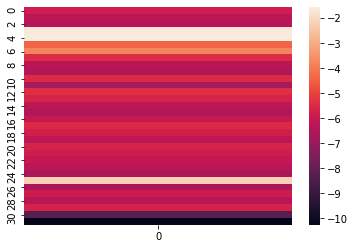

In [432]:
sns.heatmap(np.log(((f_t1_pred - f_t1).pow(2).mean(0) / f_t1.std(0).pow(2)).cpu().detach().numpy().reshape(-1, 1)))

<AxesSubplot:>

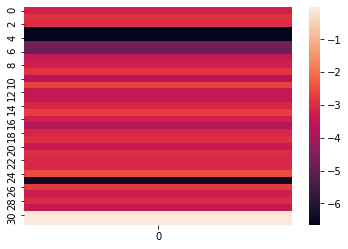

In [433]:
sns.heatmap(np.log(f_t1.std(0).pow(2).cpu().detach().numpy().reshape(-1, 1)))